In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn

# Importação dos dados

In [2]:
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("gelato_magico", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()

df.head()

df = pd.read_csv(data_asset.path)
df

Found the config file in: /config.json


,Temperature,Ice Cream Profits
0,39,13.17
1,40,11.88
2,41,18.82
3,42,18.65
4,43,17.02
...,...,...
360,99,85.13
361,99,87.08
362,99,89.29
363,101,81.91


# Análise Exploratória de Dados

In [3]:
df.shape

(365, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        365 non-null    int64  
 1   Ice Cream Profits  365 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.8 KB


In [5]:
df.describe()

,Temperature,Ice Cream Profits
count,365.000000,365.000000
mean,71.980822,52.103616
std,13.258510,15.989004
min,39.000000,11.880000
25%,63.000000,40.650000
50%,73.000000,53.620000
75%,82.000000,63.630000
max,101.000000,89.290000


## Utilizando o box plot para verificar a presença de outliers.

<Axes: >

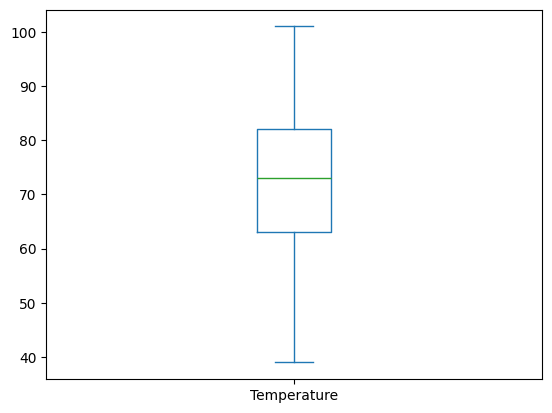

In [6]:
df['Temperature'].plot(kind='box')

<Axes: >

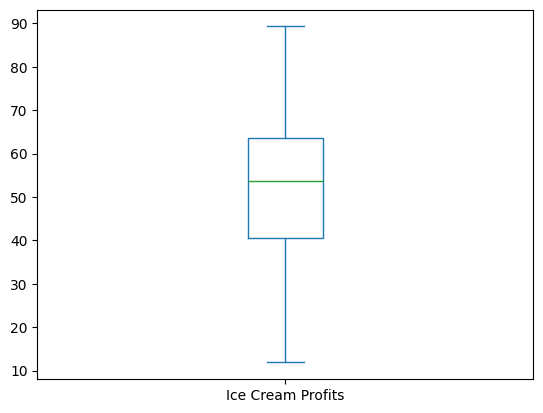

In [7]:
df['Ice Cream Profits'].plot(kind='box')

Verificar qual o comportamento da váriavel target (Ice Cream Profits) para saber qual função ela segue e determinar as melhores opções de algoritmos.

---



/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Ice Cream Profits', ylabel='Temperature'>

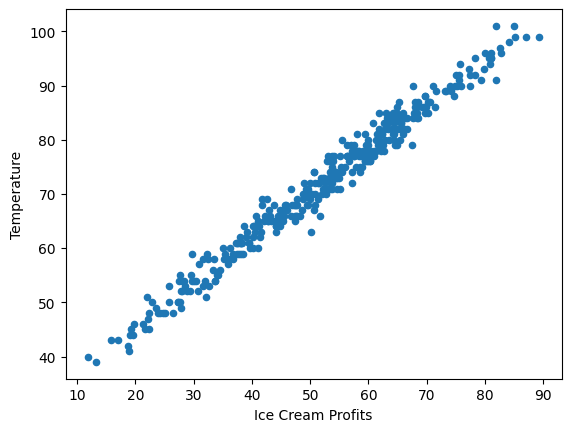

In [8]:
df.plot(kind='scatter', x='Ice Cream Profits', y='Temperature')

In [9]:
df.corr()

,Temperature,Ice Cream Profits
Temperature,1.000000,0.988446
Ice Cream Profits,0.988446,1.000000


A variável target a presenta comportamento linear e alto indice de correlação positiva com o artributo 'Temperature'.

# Pré-processamento

In [11]:
# Definir o nome
mlflow.set_experiment("Gelato-Regression_nt")

# Ativar o autologging com MLflow
mlflow.sklearn.autolog()

2025/03/24 21:21:35 INFO mlflow.tracking.fluent: Experiment with name 'Gelato-Regression_nt' does not exist. Creating a new experiment.
2025/03/24 21:21:36 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [12]:
#Separação entre features e target
X = df.drop('Ice Cream Profits', axis=1)
y = df['Ice Cream Profits']

Separando entre dados de treinamento e Validação

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construção e Treinamento do Modelo

Como o problema segue uma função linear, utilizaremos algorítimos que usam esta como base. Aquele com melhor desempenho será selecionado.

## LinearRegresion

In [14]:
mlflow.start_run()

#Definição do alg.
lr = LinearRegression()

#treinando o modelo
lr.fit(X_train, y_train)

#Testando
lr.score(X_test, y_test)

mlflow.end_run()

2025/03/24 21:21:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/03/24 21:21:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py310_sdkv2

## Criar script para componente